In [1]:
import pandas as pd
import os
from utils import *
from plots import *
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = '../data/'
PLOTS_DIR = './plots'

PVALUE = 0.05

### 1. Prepare all dfs

In [3]:
full_dfs = {
    '_'.join(os.path.splitext(file)[0].split('_')[3:]): pd.read_csv(DATA_DIR + file, decimal=',') 
    for file in os.listdir(DATA_DIR)
    }

In [4]:
text_feature_cols = list(list(full_dfs.values())[0].columns[24:])

In [5]:
len(text_feature_cols)

86

In [6]:
female_male_dfs = []

for model_name, df in full_dfs.items():
    female_df, male_df = prepare_dfs(df, text_feature_cols, model_name)
    record = {
        'model_name': model_name,
        'female_df': female_df,
        'male_df': male_df
    }
    female_male_dfs.append(record)

Missing columns: {'pronoun_LIWC'} in qwen_4B
Missing columns: {'pronoun_LIWC'} in qwen_14B


### 2. Calculate Cohen's d

In [7]:
all_cohens_ds = dict()

for record in female_male_dfs:
    cohens_ds = get_sorted_cohens_d(record['male_df'], record['female_df'], text_feature_cols, model_name)
    all_cohens_ds[record['model_name']] = cohens_ds

Missing columns: {'pronoun_LIWC'} in qwen_14B
Missing columns: {'pronoun_LIWC'} in qwen_14B


### 3. Plot per every model Cohen's d

In [8]:
for model_name, cohens_ds in all_cohens_ds.items():
    plot_cohens_d_features(cohens_ds, model_name, path_to_save=PLOTS_DIR+'/cohens_d_model', show=False)

### 4. Values that were most often in the top 10 in Cohen's d

In [9]:
counter_cohens_d = []
num_top_values = 10

for model_name, cohens_ds in all_cohens_ds.items():
    top_10 = [feature for feature, _ in zip(cohens_ds.keys(), range(num_top_values)) if feature != 'male']
    counter_cohens_d.extend(top_10)

most_common_cohens_d = Counter(counter_cohens_d).most_common(num_top_values)
most_common_cohens_d

[('WC', 10),
 ('i', 10),
 ('unique_words_cnt', 9),
 ('Clout', 7),
 ('prosocial', 6),
 ('female', 5),
 ('comm', 4),
 ('you', 4),
 ('differ', 4),
 ('negate', 4)]

In [10]:
for feature, frequency in most_common_cohens_d[:num_top_values]:
    feature_cohens_d = dict()
    
    for model_name, cohens_d in all_cohens_ds.items():
        try:
            feature_cohens_d[model_name] = cohens_d[feature]
        except KeyError: # ('pronoun_LIWC' attacks again)
            continue
    
    plot_cohens_d_features(feature_cohens_d, feature, PLOTS_DIR+'/cohens_d_feature', show=False, model_grouping=True) 

### 5. Total Cohen's d in every model

In [11]:
total_cohens_d = dict()

for model_name, cohens_ds in all_cohens_ds.items():
    
    total =  np.mean(np.abs(np.array(list(cohens_ds.values()))))
    total_cohens_d[model_name] = total

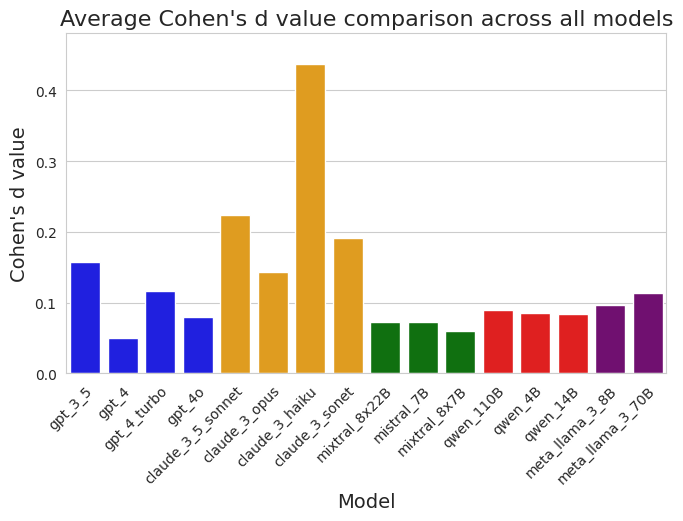

In [12]:
plot_total_cohens_d(total_cohens_d)

### 6. Distributions

In [13]:
# for record in female_male_dfs:
#     female_df = record['female_df']
#     male_df = record['male_df']
    
#     wilcoxon_pvalues = compute_wilcoxon_pvalues(female_df, male_df, text_feature_cols, record['model_name'])
#     wilcoxon_pvalues_0_05 = {feature: pvalue for feature, pvalue in wilcoxon_pvalues.items() if pvalue < PVALUE}
    
#     plot_features_distribution(male_df, female_df, wilcoxon_pvalues_0_05, PVALUE, record['model_name'], path_to_save=PLOTS_DIR+'/distributions', show=False)
    